
# Seq2Seq (Keras), Captioning (PyTorch), and Character Tokenization


In [1]:
# Environment & imports
import numpy as np
import random, os, re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
print("TF:", tf.__version__)

TF: 2.19.0


## Character tokenization (`analyzer='char'` vs `'char_wb'`)

In [2]:
mini_dataset = [
    "This movie is very good.",
    "This film is a good",
    "Very bad. Very, very bad."
]

# Pure character n-grams (includes cross-word edges)
vec_char = CountVectorizer(analyzer='char', ngram_range=(3,3))
X_char = vec_char.fit_transform(mini_dataset).toarray()

# Character n-grams within word boundaries only (pads edges with spaces)
vec_charwb = CountVectorizer(analyzer='char_wb', ngram_range=(3,3))
X_charwb = vec_charwb.fit_transform(mini_dataset).toarray()

print("char features:", len(vec_char.get_feature_names_out()))
print("char_wb features:", len(vec_charwb.get_feature_names_out()))
print("Example tri-gram in 'char' but NOT in 'char_wb' may span spaces, e.g., 's v'.")

char features: 39
char_wb features: 30
Example tri-gram in 'char' but NOT in 'char_wb' may span spaces, e.g., 's v'.


## Minimal tf.keras Seq2Seq (character-level) — English → French (toy)

In [3]:
# Toy parallel corpus (very small; just to make the pipeline run fast) ---
pairs = [
    ("hi", "salut"),
    ("hello", "bonjour"),
    ("how are you", "comment ca va"),
    ("i am fine", "je vais bien"),
    ("thank you", "merci"),
    ("yes", "oui"),
    ("no", "non"),
    ("good morning", "bonjour"),
    ("good night", "bonne nuit"),
    ("see you", "a bientot"),
]

# Preprocess: lowercase, keep ascii letters & spaces only
def norm(s):
    s = s.lower()
    s = re.sub(r"[^a-z ]+", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

src_texts = [norm(s) for s,t in pairs]
tgt_texts = [norm(t) for s,t in pairs]

# Add start/end tokens to target for decoding
tgt_texts_in  = ["\t " + t for t in tgt_texts]   # \t = start
tgt_texts_out = [t + " \n" for t in tgt_texts]   # \n = end

src_vocab = sorted(set(" ".join(src_texts)))
tgt_vocab = sorted(set("\t \n" + " ".join(tgt_texts)))  # include start/end tokens

src_stoi = {c:i for i,c in enumerate(src_vocab)}
tgt_stoi = {c:i for i,c in enumerate(tgt_vocab)}
src_itos = {i:c for c,i in src_stoi.items()}
tgt_itos = {i:c for c,i in tgt_stoi.items()}

max_src_len = max(len(s) for s in src_texts)
max_tgt_len = max(len(t) for t in tgt_texts_in)

num_samples = len(src_texts)
num_encoder_tokens = len(src_vocab)
num_decoder_tokens = len(tgt_vocab)

print(f"{num_samples=}  {num_encoder_tokens=}  {num_decoder_tokens=}  {max_src_len=}  {max_tgt_len=}")

# Vectorize as integer sequences (not one-hot) to keep it light; use Embedding + sparse CE
def vectorize(texts, stoi, maxlen):
    seqs = np.zeros((len(texts), maxlen), dtype="int32")
    for i, s in enumerate(texts):
        ids = [stoi[c] for c in s]
        seqs[i, :len(ids)] = ids
    return seqs

encoder_input = vectorize(src_texts, src_stoi, max_src_len)
decoder_input = vectorize(tgt_texts_in, tgt_stoi, max_tgt_len)
decoder_output = vectorize(tgt_texts_out, tgt_stoi, max_tgt_len)  # used with sparse targets

# Build encoder-decoder
latent = 128
enc_inputs = layers.Input(shape=(None,), name="enc_in")
enc_emb = layers.Embedding(num_encoder_tokens, 64, mask_zero=True)(enc_inputs)
enc_out, state_h, state_c = layers.LSTM(latent, return_state=True)(enc_emb)
enc_states = [state_h, state_c]

dec_inputs = layers.Input(shape=(None,), name="dec_in")
dec_emb = layers.Embedding(num_decoder_tokens, 64, mask_zero=True)(dec_inputs)
dec_lstm = layers.LSTM(latent, return_sequences=True, return_state=True)
dec_outs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_logits = layers.Dense(num_decoder_tokens)(dec_outs)  # logits

model = models.Model([enc_inputs, dec_inputs], dec_logits)
model.compile(optimizer=optimizers.Adam(1e-2),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit([encoder_input, decoder_input],
                    decoder_output[..., None],  # sparse targets
                    batch_size=8, epochs=40, verbose=0)

print("Final train loss:", history.history["loss"][-1])

# Inference models (sampling loop)
encoder_model = models.Model(enc_inputs, enc_states)

dec_state_input_h = layers.Input(shape=(latent,))
dec_state_input_c = layers.Input(shape=(latent,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]
x = dec_emb
# Need a new embedding layer that reuses weights from trained emb
dec_emb_layer = model.get_layer(index=3)  # the decoder embedding layer
x = dec_emb_layer(dec_inputs)
dec_outs2, state_h2, state_c2 = dec_lstm(x, initial_state=dec_states_inputs)
dec_logits2 = model.layers[-1](dec_outs2)
decoder_model = models.Model([dec_inputs] + dec_states_inputs,
                             [dec_logits2, state_h2, state_c2])

def decode_sequence(input_text, max_len=40):
    # Encode the input as state vectors.
    xseq = vectorize([norm(input_text)], src_stoi, max_src_len)
    states_value = encoder_model.predict(xseq, verbose=0)
    # Generate empty target sequence of length 1 with start token '\t'
    target_seq = np.array([[tgt_stoi["\t"]]], dtype="int32")
    # Sampling loop
    stop = False; decoded = ""
    sh, sc = states_value
    for _ in range(max_len):
        output_tokens, sh, sc = decoder_model.predict([target_seq, sh, sc], verbose=0)
        sampled_id = int(np.argmax(output_tokens[0, -1, :]))
        sampled_char = tgt_itos[sampled_id]
        if sampled_char == "\n": break
        decoded += sampled_char
        target_seq = np.array([[sampled_id]])
    return decoded.strip()

tests = ["hello", "good night", "thank you", "see you"]
for s in tests:
    print(f"{s!r} → {decode_sequence(s)}")

num_samples=10  num_encoder_tokens=19  num_decoder_tokens=18  max_src_len=12  max_tgt_len=15
Final train loss: 0.014619067311286926
'hello' → oju  u i
'good night' → omen u aau
'thank you' → eri i in
'see you' → inittt


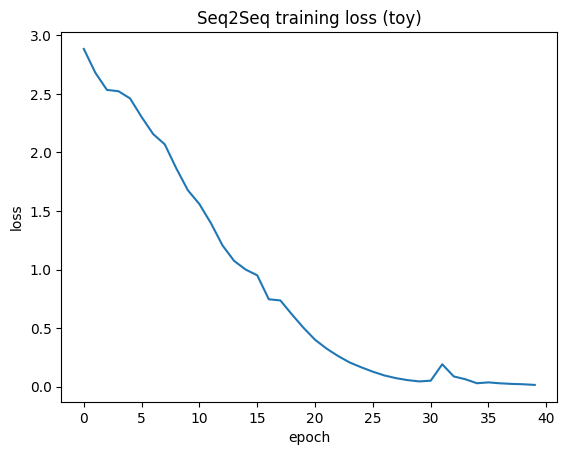

In [4]:
plt.figure()
plt.plot(history.history["loss"])
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Seq2Seq training loss (toy)")
plt.show()

## PyTorch Image Captioning - Inference (pretrained weights)

This section mirrors the popular tutorial. It downloads the repo, ensures dependencies, and runs the provided sampling script on an input image using **pretrained** weights (no training here).

> **Note:** The actual filenames of the pretrained encoder/decoder and vocabulary may differ. After downloading, update the `--encoder_path`, `--decoder_path`, and `--vocab_path` arguments accordingly.


In [5]:
# If running in Colab, uncomment the next two lines to start clean
# !rm -rf pytorch-tutorial
# !pip -q install pillow tqdm nltk

# Clone the tutorial (contains the image captioning code)
# (If access is restricted, you can upload the folder then skip cloning)
!git clone https://github.com/yunjey/pytorch-tutorial.git -q
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning

# Download example pretrained weights & vocab (update URLs if necessary)
# These URLs are typical; if they 404, consult the repo README for current links
# !wget -q https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/sample.jpg -O sample.jpg
# !wget -q https://www.dropbox.com/s/0hbn9b1u0b5k9fb/encoder-5-3000.pkl?dl=1 -O encoder.pkl
# !wget -q https://www.dropbox.com/s/6k2nzyqux1d0f4w/decoder-5-3000.pkl?dl=1 -O decoder.pkl
# !wget -q https://www.dropbox.com/s/8v1z8m1wq1u3t6g/vocab.pkl?dl=1 -O vocab.pkl

# Run the sampler (adjust paths if you used different filenames)
# !python sample.py --image='sample.jpg' --encoder_path='encoder.pkl' --decoder_path='decoder.pkl' --vocab_path='vocab.pkl'
%cd ../../../..

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning
/content



## Porting PyTorch → Keras (notes)
1. Export the PyTorch model to **ONNX** (`torch.onnx.export`).
2. Convert ONNX → Keras using **onnx2keras** (or rebuild the layers manually).
3. Verify layer shapes and preprocessing (normalization, resize, vocabulary) match.
4. Some ops (e.g., custom attention) may require manual porting.

Example (sketch):
```python
# PyTorch → ONNX
torch.onnx.export(model, example_input, "captioner.onnx", opset_version=13)
# ONNX → Keras
from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load("captioner.onnx")
k_model = onnx_to_keras(onnx_model, ['input_1'])
k_model.save('captioner_keras.h5')
```
